In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import datetime
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib.dates as mdates
import seaborn as sns

/Users/asumisaito/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/asumisaito/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/asumisaito/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import classification_report
from sklearn import ensemble
from sklearn.metrics import confusion_matrix

/Users/asumisaito/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# 1. Read data

In [3]:
# train
df = pd.read_csv('/Users/asumisaito/Downloads/dengue_features_train.csv')
df2 = pd.read_csv('/Users/asumisaito/Downloads/dengue_labels_train.csv')
df.head(3)

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,1990,18,1990-04-30,0.12260,0.103725,0.198483,0.177617,12.42,297.572857,...,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,sj,1990,19,1990-05-07,0.16990,0.142175,0.162357,0.155486,22.82,298.211429,...,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,sj,1990,20,1990-05-14,0.03225,0.172967,0.157200,0.170843,34.54,298.781429,...,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4


In [19]:
train = pd.merge(df, df2, on = ['city', 'year', 'weekofyear'])

### get year and month

In [20]:
import datetime
train['date'] = train['week_start_date'].astype(str).apply(lambda x: pd.to_datetime(x, format='%Y-%m-%d'))

In [11]:
train.date.describe()

count                    1456
unique                   1049
top       2005-01-29 00:00:00
freq                        2
first     1990-04-30 00:00:00
last      2010-06-25 00:00:00
Name: date, dtype: object

In [21]:
from datetime import date
train['month'] = train['date'].dt.month

### convert city to dummy

In [22]:
mapping = {'sj': 0, 'iq': 1}
train2 = train.replace(mapping)
train2.head(3)

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases,date,month
0,0,1990,18,1990-04-30,0.12260,0.103725,0.198483,0.177617,12.42,297.572857,...,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4,1990-04-30,4
1,0,1990,19,1990-05-07,0.16990,0.142175,0.162357,0.155486,22.82,298.211429,...,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5,1990-05-07,5
2,0,1990,20,1990-05-14,0.03225,0.172967,0.157200,0.170843,34.54,298.781429,...,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4,1990-05-14,5


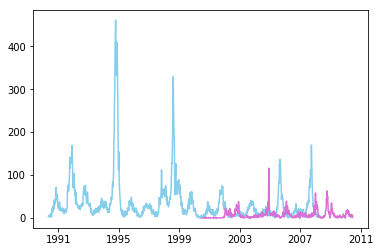

In [58]:
x0 = train2[train2.city == 0].date
x1 = train2[train2.city == 1].date
y0 = train2[train2.city == 0].total_cases
y1 = train2[train2.city == 1].total_cases
plt.plot(x0, y0, color = 'skyblue')
plt.plot(x1, y1, color = 'orchid')
plt.show()

# 2. Model

In [24]:
list(train2)

['city',
 'year',
 'weekofyear',
 'week_start_date',
 'ndvi_ne',
 'ndvi_nw',
 'ndvi_se',
 'ndvi_sw',
 'precipitation_amt_mm',
 'reanalysis_air_temp_k',
 'reanalysis_avg_temp_k',
 'reanalysis_dew_point_temp_k',
 'reanalysis_max_air_temp_k',
 'reanalysis_min_air_temp_k',
 'reanalysis_precip_amt_kg_per_m2',
 'reanalysis_relative_humidity_percent',
 'reanalysis_sat_precip_amt_mm',
 'reanalysis_specific_humidity_g_per_kg',
 'reanalysis_tdtr_k',
 'station_avg_temp_c',
 'station_diur_temp_rng_c',
 'station_max_temp_c',
 'station_min_temp_c',
 'station_precip_mm',
 'total_cases',
 'date',
 'month']

In [25]:
features=[
    'city',
 'year',
 'weekofyear',
 #'week_start_date',
 'ndvi_ne',
 'ndvi_nw',
 'ndvi_se',
 'ndvi_sw',
 'precipitation_amt_mm',
 'reanalysis_air_temp_k',
 'reanalysis_avg_temp_k',
 'reanalysis_dew_point_temp_k',
 'reanalysis_max_air_temp_k',
 'reanalysis_min_air_temp_k',
 'reanalysis_precip_amt_kg_per_m2',
 'reanalysis_relative_humidity_percent',
 'reanalysis_sat_precip_amt_mm',
 'reanalysis_specific_humidity_g_per_kg',
 'reanalysis_tdtr_k',
 'station_avg_temp_c',
 'station_diur_temp_rng_c',
 'station_max_temp_c',
 'station_min_temp_c',
 'station_precip_mm',
 #'total_cases',
 #'date',
 'month'
]

In [29]:
train3 = train2.dropna()
X = train3.loc[:, features]
y = train3.loc[:, ['total_cases']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

### 1. Gradient Boosting

In [32]:
from sklearn.metrics import mean_absolute_error
gb = ensemble.GradientBoostingRegressor()
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)
MAE = mean_absolute_error(y_test, y_pred)
print('mean absolute error: ', MAE)

mean absolute error:  12.206742733740356


/Users/asumisaito/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [33]:
gb

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [ ]:
# 14:58 - 

In [37]:
# grid search cv
gb_parameters = {'n_estimators': [100, 300, 500], 
                 'learning_rate': [0.001, 0.01, 0.1], 
                 'max_depth': range(2, 7, 2)
                }
gb_grid = GridSearchCV(gb, param_grid = gb_parameters, cv = 3, verbose=1)
gb_grid.fit(X_train, y_train)

gb_params = gb_grid.best_params_

tuned_gb = ensemble.GradientBoostingRegressor(**gb_params)
tuned_gb.fit(X_train, y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


/Users/asumisaito/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/asumisaito/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/asumisaito/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/asumisaito/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expec

/Users/asumisaito/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/asumisaito/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/asumisaito/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/asumisaito/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expec

/Users/asumisaito/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/asumisaito/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/asumisaito/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/asumisaito/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expec

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=4, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=500, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [39]:
y_pred = tuned_gb.predict(X_test)
MAE = mean_absolute_error(y_test, y_pred)
print('mean absolute error: ', MAE)

mean absolute error:  11.19453715648107


In [43]:
# grid search cv
gb_parameters = {'n_estimators': [500, 700, 1000], 
                 'learning_rate': [0.001, 0.01], 
                 'max_depth': range(2, 7, 2)
                }
gb_grid = GridSearchCV(gb, param_grid = gb_parameters, cv = 5, verbose=1)
gb_grid.fit(X_train, y_train)

gb_params = gb_grid.best_params_

tuned_gb = ensemble.GradientBoostingRegressor(**gb_params)
tuned_gb.fit(X_train, y_train)
y_pred = tuned_gb.predict(X_test)
MAE = mean_absolute_error(y_test, y_pred)
print('mean absolute error: ', MAE)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


/Users/asumisaito/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/asumisaito/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/asumisaito/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/asumisaito/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expec

/Users/asumisaito/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/asumisaito/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/asumisaito/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/asumisaito/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expec

/Users/asumisaito/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/asumisaito/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/asumisaito/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/asumisaito/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expec

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  1.8min finished
/Users/asumisaito/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


mean absolute error:  11.301814883036677


In [46]:
tuned_gb

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='ls', max_depth=6, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=1000, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [44]:
import xgboost as xgb

In [50]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', 
                          colsample_bytree = 0.4, 
                          learning_rate = 0.1,
                          max_depth = 5, 
                          alpha = 0.9, 
                          n_estimators = 20)

model = xg_reg.fit(X_train,y_train)
y_pred = xg_reg.predict(X_test)
MAE = mean_absolute_error(y_test, y_pred)
print('mean absolute error: ', MAE)

mean absolute error:  12.008324269453684


# 3. Model by city

In [61]:
sj = train3[train3.city == 0]
iq = train3[train3.city == 1]

In [62]:
# sj
X = sj.loc[:, features]
y = sj.loc[:, ['total_cases']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [63]:
gb = ensemble.GradientBoostingRegressor()
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)
MAE = mean_absolute_error(y_test, y_pred)
print('mean absolute error: ', MAE)

mean absolute error:  15.753227059304539


/Users/asumisaito/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [64]:
# iq
X = iq.loc[:, features]
y = iq.loc[:, ['total_cases']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

gb = ensemble.GradientBoostingRegressor()
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)
MAE = mean_absolute_error(y_test, y_pred)
print('mean absolute error: ', MAE)

mean absolute error:  4.217220543577337


/Users/asumisaito/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
